In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### LangGraph 활용 Agent 구축

In [2]:
from langchain_teddynote.tools.tavily import TavilySearch

In [3]:
# 검색 도구 생성
tool = TavilySearch(max_results=3)      

# 도구 목록에 추가
tools = [tool]      

In [4]:
print(tool.invoke("소놀코딩"))

["<document><title>소놀코딩 유튜브 채널로 코딩 배워보세요 : 네이버 블로그</title><url>https://m.blog.naver.com/nasu0210/222428706773</url><content>소놀코딩 유튜브 채널로 코딩 배워보세요 : 네이버 블로그 소놀코딩 유튜브 채널로 코딩 배워보세요 소놀코딩과 함께 하시는 많은 분들이 코딩 학습을 통해 문제해결력과 창의력을 키워 4차 산업혁명시대의 필수 인재로 성장할 수 있도록 돕고자 합니다. 소놀코딩 유튜브 채널에는 다양한 강의가 있습니다. 파이썬 강의입니다. 파이썬 왕기초, 기초, 중급 강의가 있습니다. C언어 강의입니다. 아두이노 강의입니다. 앱인벤터 강의입니다. 여러가지 메이커 프로젝트를 진행하면 코딩에 더욱 재미를 느낄 수 있습니다. 매주 금요일 7시에는 파이썬 왕기초 문제 풀이 강의를 업로드 하고 있습니다. 소프트웨어놀이터(코딩&메이커) : 네이버 카페코딩콘텐츠,SW,스크래치,앱인벤터2,아두이노,C언어, C#, 파이썬,IoT,사물인터넷, 클라우드, 빅데이터,웹 cafe.naver.com 소놀코딩_Sonol Coding소놀코딩은 코딩을 연구하고 공부하며 그 내용을 많은 분들과 나누고자 하는 채널입니다. 소놀코딩과 함께 하시는 많은 분들이 코딩 학습을 통해 문제해결력과 창의력을 키워 4차 산업혁명시대(인공지능, 사물인터넷, 빅데이터, 클라우드 등)의 필수 인재로 성장 할 수 있도록 돕고자 합니다. {\\\"title\\\":\\\"소놀코딩 유튜브 채널로 코딩 배워보세요\\\",\\\"source\\\":\\\"https://blog.naver.com/nasu0210/222428706773\\\",\\\"blogName\\\":\\\"소놀코딩[..\\\",\\\"domainIdOrBlogId\\\":\\\"nasu0210\\\",\\\"nicknameOrBlogId\\\":\\\"복쌤\\\",\\\"logNo\\\":222428706773,\\\"smartEditorVersion\\\":

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
from langchain_openai import ChatOpenAI

In [8]:
llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])

    return {"messages": [answer]}

In [11]:
from langgraph.graph import StateGraph

In [12]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

In [13]:
# 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [14]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []

        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])

            outputs.append(
                
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}

In [15]:
# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

In [16]:
# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [17]:
from langgraph.graph import START, END

In [18]:
def route_tools(state: State,):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")


    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:     # 도구 호출이 있는 경우 "tools" 반환       
        return "tools"     

    return END              # 도구 호출이 없는 경우 "END" 반환

In [19]:
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,    
    path_map={"tools": "tools", END: END},      # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
)

In [20]:
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

In [21]:
# START > chatbot
graph_builder.add_edge(START, "chatbot")

In [22]:
# 그래프 컴파일
graph = graph_builder.compile()

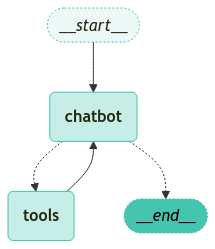

In [23]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [24]:
inputs = {"messages": "소놀코딩 YouTube 채널에 대해서 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='소놀코딩 YouTube 채널에 대해서 검색해 줘' additional_kwargs={} response_metadata={} id='f168714c-5ba4-4f6d-b557-3a6045a7fa93'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_YpLBPC5doGzrJoVPWM27yyC3', 'function': {'arguments': '{"query":"소놀코딩 YouTube 채널"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 105, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_01aeff40ea', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9f505a30-ed27-4464-a5ec-589d1e8ad1a9-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '소놀코딩 YouTube 채널'}, 'id': 'call_YpLBPC5doGzrJoVPWM27yyC3', 'type': 'tool_call'}] usage_me